#**Bitcoin Blockchain Analysis**
###Motivation is to perform statistical analysis on the blockchain network and draw basic inferences on the factors that may be affecting it.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import numpy as np
import statsmodels.api as sm
%matplotlib inline


#Reading data from the input directory
bitcoin_data = pd.read_csv('/content/bitcoin_dataset.csv', header=0, parse_dates=['Date'])
bitcoin_data['Year'] = bitcoin_data['Date'].apply(lambda x: x.year)
bitcoin_data['Month'] = bitcoin_data['Date'].apply(lambda x: x.month)
bitcoin_data.head(3)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,Date,btc_market_price,btc_total_bitcoins,btc_market_cap,btc_trade_volume,btc_blocks_size,btc_avg_block_size,btc_n_orphaned_blocks,btc_n_transactions_per_block,btc_median_confirmation_time,btc_hash_rate,btc_difficulty,btc_miners_revenue,btc_transaction_fees,btc_cost_per_transaction_percent,btc_cost_per_transaction,btc_n_unique_addresses,btc_n_transactions,btc_n_transactions_total,btc_n_transactions_excluding_popular,btc_n_transactions_excluding_chains_longer_than_100,btc_output_volume,btc_estimated_transaction_volume,btc_estimated_transaction_volume_usd,Year,Month
0,2009-10-06,0.0,1222700.0,0.0,0.0,0.0,0.000261,0.0,1.0,0.0,0.000002,1.0,0.0,0.0,1025.0,0.0,42.0,43.0,24612.0,43.0,43.0,2950.0,200.0,0.0,2009,10
1,2009-10-07,0.0,1225250.0,0.0,0.0,0.0,0.000216,0.0,1.0,0.0,0.000003,1.0,0.0,0.0,0.0,0.0,51.0,51.0,24663.0,51.0,51.0,2550.0,0.0,0.0,2009,10
2,2009-10-08,0.0,1228750.0,0.0,0.0,0.0,0.000215,0.0,1.0,0.0,0.000003,1.0,0.0,0.0,0.0,0.0,70.0,70.0,24733.0,70.0,70.0,3500.0,0.0,0.0,2009,10


In [ ]:
list(bitcoin_data.columns)

['Date',
 'btc_market_price',
 'btc_total_bitcoins',
 'btc_market_cap',
 'btc_trade_volume',
 'btc_blocks_size',
 'btc_avg_block_size',
 'btc_n_orphaned_blocks',
 'btc_n_transactions_per_block',
 'btc_median_confirmation_time',
 'btc_hash_rate',
 'btc_difficulty',
 'btc_miners_revenue',
 'btc_transaction_fees',
 'btc_cost_per_transaction_percent',
 'btc_cost_per_transaction',
 'btc_n_unique_addresses',
 'btc_n_transactions',
 'btc_n_transactions_total',
 'btc_n_transactions_excluding_popular',
 'btc_n_transactions_excluding_chains_longer_than_100',
 'btc_output_volume',
 'btc_estimated_transaction_volume',
 'btc_estimated_transaction_volume_usd',
 'Year',
 'Month',
 'Avg_Txn_Fee']

###Visualize the times when the network observed increase in its number of transactions.

In [ ]:
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
parameters = {
  'start':'1',
  'limit':'5000',
  'convert':'USD'
}
headers = {
  'Accepts': 'application/json',
  'X-CMC_PRO_API_KEY': 'ff08d92e-c629-4b09-8949-f1454623a11a',
}

session = Session()
session.headers.update(headers)

try:
  response = session.get(url, params=parameters)
  data = json.loads(response.text)
  print(data)
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)
  

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



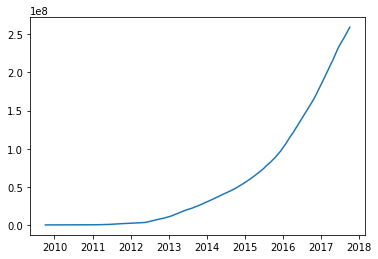

In [ ]:
plt.plot(bitcoin_data['Date'], bitcoin_data['btc_n_transactions_total'])
plt.show()

###Visualize the increase of the processing power of the miners (hash_rate) of the respective cryptocurrency. We do this with respect to the entire network as function of time.

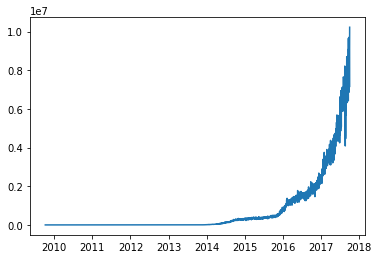

In [ ]:
plt.plot(bitcoin_data['Date'], bitcoin_data['btc_hash_rate'])
plt.show()

###The network seemed to get users and increased support of mining power from 2015 onwards. 
### This way, it is possible to focus on activities from 2015 onwards and filter our dataset accordingly.

In [ ]:
bitcoin_data = bitcoin_data.loc[bitcoin_data['Date'] > datetime(2015,1,1)]

# Transform the total number of transactions into a scale of million
bitcoin_data['btc_n_transactions_total'] = bitcoin_data['btc_n_transactions_total']/1000000

# The dataset has btc_miners_revenue which is basically total value in bitcoin earned by miners. 
# However, from user perspective who wants to transact bitcoin, we should define another parameter. This
# parameter should provide a measure of average cost incurred by the user per transaction
bitcoin_data['Avg_Txn_Fee'] = bitcoin_data['btc_transaction_fees']/bitcoin_data['btc_n_transactions_total']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### Relationship between variables.

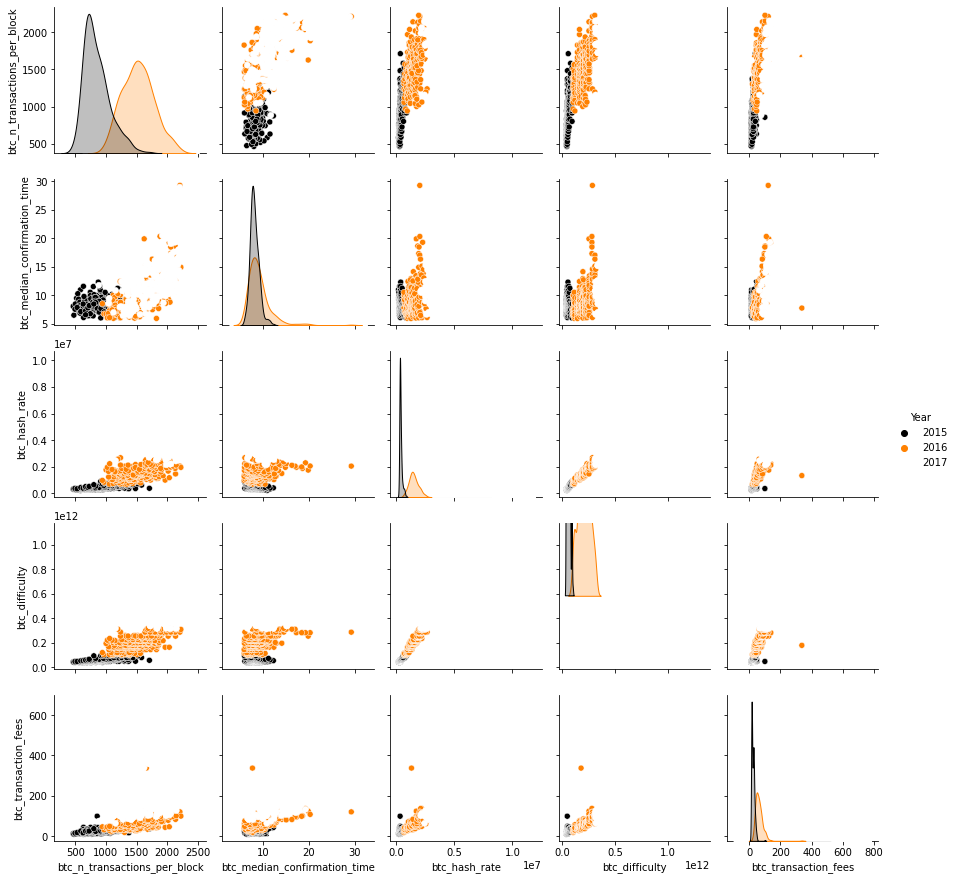

In [ ]:
sns.pairplot(bitcoin_data[bitcoin_data.columns[[8,9,10,11,13,24]]],hue='Year',palette='afmhot')

###Key observations

*   Median confirmation time for a transaction (btc_median_confirmation_time) shows somewhat exponential relationship with avg. transactions per block (btc_n_transactions_per_block)
*   Hash Rate and Difficulty level of the blockchain have strong linear relation. This is expected since larger hash rate will result in faster mining of blocks and the difficulty level will be set accordingly. Please refer Bitcoin Core reference docs for more details.
*   Median confirmation time also exhibits relationship with btc_transaction_fees.
*   Next step, exploration of points 1 and 3.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(29.455909288194448, 0.5, 'Median Time')

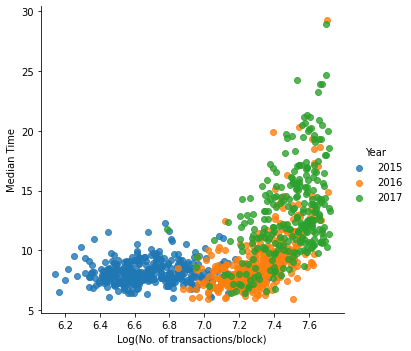

In [ ]:
# Median Txn time vs. Log(no. of transactions per block)
sns.lmplot('btc_n_transactions_per_block','btc_median_confirmation_time',
           data= pd.concat([bitcoin_data['btc_median_confirmation_time'],
            np.log(bitcoin_data['btc_n_transactions_per_block']),
            bitcoin_data['Year']],axis=1),hue='Year',fit_reg=False)

plt.xlabel('Log(No. of transactions/block)')
plt.ylabel('Median Time')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(29.455909288194448, 0.5, 'Median Time')

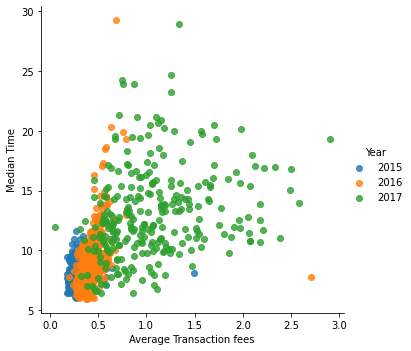

In [ ]:
# Median Txn time vs Avg fee per transaction
sns.lmplot('Avg_Txn_Fee','btc_median_confirmation_time',
           data= pd.concat([bitcoin_data['btc_median_confirmation_time'],
            bitcoin_data['Year'], bitcoin_data['Avg_Txn_Fee']], axis=1),hue='Year',fit_reg=False)

plt.xlabel('Average Transaction fees')
plt.ylabel('Median Time')

###We see two outliers in 2016 data. Median time close to 30 and Avg. transaction fees > 2.5. Other parameters for these observations are well within their usual ranges and also there was no significant news on that day. Hence, we rule the likely occurence of such possibility and remove these data inputs.

In [ ]:
bitcoin_data_2015 = bitcoin_data.loc[bitcoin_data['Year']==2015]
bitcoin_data_2016 = bitcoin_data.loc[bitcoin_data['Year']==2016]
bitcoin_data_2017 = bitcoin_data.loc[bitcoin_data['Year']==2017]

bitcoin_data_2016 = bitcoin_data_2016.loc[bitcoin_data_2016['btc_median_confirmation_time'] < 25]
bitcoin_data_2016 = bitcoin_data_2016.loc[bitcoin_data_2016['Avg_Txn_Fee'] < 2.5]

In [ ]:
# Lets check the correlation between btc_n_transactions_per_block and Avg_Txn_Fee
print(np.corrcoef(bitcoin_data.loc[bitcoin_data['Year'] == 2015,'btc_n_transactions_per_block'],
            bitcoin_data.loc[bitcoin_data['Year'] == 2015, 'Avg_Txn_Fee'])[0][1])

print(np.corrcoef(bitcoin_data.loc[bitcoin_data['Year'] == 2016,'btc_n_transactions_per_block'],
            bitcoin_data.loc[bitcoin_data['Year'] == 2016, 'Avg_Txn_Fee'])[0][1])

print(np.corrcoef(bitcoin_data.loc[bitcoin_data['Year'] == 2017,'btc_n_transactions_per_block'],
            bitcoin_data.loc[bitcoin_data['Year'] == 2017, 'Avg_Txn_Fee'])[0][1])

0.3036426315945996
0.394117657219305
0.4598550401873434


###Not much correlation, so we can include these two variables in multiple regression.

In [ ]:
# Regression year 2015
# Median confirmation time ~ log(no. of transactions/block) + average transaction fee
reg_data_2015 = bitcoin_data_2015[['btc_median_confirmation_time', 'btc_n_transactions_per_block', 
                                   'Avg_Txn_Fee']]
reg_data_2015['log_txn_block'] = reg_data_2015['btc_n_transactions_per_block'].apply(lambda x: np.log(x))
reg_data_2015 = reg_data_2015.drop('btc_n_transactions_per_block', axis=1)
reg_data_2015_exog = sm.add_constant(reg_data_2015[['Avg_Txn_Fee', 'log_txn_block']], prepend=False)
model_2015 = sm.OLS(reg_data_2015['btc_median_confirmation_time'],reg_data_2015_exog)
model_2015.fit().summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     btc_median_confirmation_time   R-squared:                       0.033
Model:                                      OLS   Adj. R-squared:                  0.027
Method:                           Least Squares   F-statistic:                     6.075
Date:                          Wed, 24 Nov 2021   Prob (F-statistic):            0.00254
Time:                                  18:13:13   Log-Likelihood:                -500.20
No. Observations:                           364   AIC:                             1006.
Df Residuals:                               361   BIC:                             1018.
Df Model:                                     2                                         
Covariance Type:                      nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Avg_Txn_Fee       1.7988      0.519      3.463      0.001       0.777       2.820
log_txn_block    -0.1509      0.224     -0.673      0.501      -0.591       0.290
const             8.6486      1.466      5.898      0.000       5.765      11.532
==============================================================================
Omnibus:                       39.514   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.269
Skew:                           0.738   Prob(JB):                     6.04e-13
Kurtosis:                       4.238   Cond. No.                         201.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###Poor fit as demonstrated by R-squared statistic.

In [ ]:
# Regression year 2016
# Median confirmation time ~ log(no. of transactions/block) + average transaction fee
reg_data_2016 = bitcoin_data_2016[['btc_median_confirmation_time', 'btc_n_transactions_per_block', 'Avg_Txn_Fee']]
reg_data_2016['log_txn_block'] = reg_data_2016['btc_n_transactions_per_block'].apply(lambda x: np.log(x))
reg_data_2016 = reg_data_2016.drop('btc_n_transactions_per_block', axis=1)
reg_data_2016_exog = sm.add_constant(reg_data_2016[['Avg_Txn_Fee', 'log_txn_block']], prepend=False)
model_2016 = sm.OLS(reg_data_2016['btc_median_confirmation_time'],reg_data_2016_exog)
model_2016.fit().summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     btc_median_confirmation_time   R-squared:                       0.448
Model:                                      OLS   Adj. R-squared:                  0.445
Method:                           Least Squares   F-statistic:                     146.5
Date:                          Wed, 24 Nov 2021   Prob (F-statistic):           2.56e-47
Time:                                  18:13:13   Log-Likelihood:                -706.41
No. Observations:                           364   AIC:                             1419.
Df Residuals:                               361   BIC:                             1431.
Df Model:                                     2                                         
Covariance Type:                      nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Avg_Txn_Fee       9.8409      1.204      8.172      0.000       7.473      12.209
log_txn_block     4.8064      0.643      7.474      0.000       3.542       6.071
const           -30.2551      4.426     -6.836      0.000     -38.959     -21.551
==============================================================================
Omnibus:                       93.851   Durbin-Watson:                   1.468
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              259.560
Skew:                           1.203   Prob(JB):                     4.34e-57
Kurtosis:                       6.366   Cond. No.                         377.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###Key observations

- Avg_Txn_Fee has positive significant co-efficient meaning miners select transactions into a current block rather greedily which results in delay on average for a transaction with average transaction fees associated with it to get accepted into a block.
- This is corroborated by research paper by Bitfury Group as well which says that miners first order the transactions by decreasing fee density (transaction fees/size of txn) and then select them.
- Increase in the number of transactions within a block increases the block size, thereby requiring more time to validate it via proof of work and more time to propogate it over the network. This is known as impedance for a block.
- This is witnessed by observing the positive co-efficient for log(no_txn_block).

In [ ]:
# Regression year 2017
# Median confirmation time ~ log(no. of transactions/block) + average transaction fee
reg_data_2017 = bitcoin_data_2017[['btc_median_confirmation_time', 'btc_n_transactions_per_block', 'Avg_Txn_Fee']]
reg_data_2017['log_txn_block'] = reg_data_2017['btc_n_transactions_per_block'].apply(lambda x: np.log(x))
reg_data_2017 = reg_data_2017.drop('btc_n_transactions_per_block', axis=1)
reg_data_2017_exog = sm.add_constant(reg_data_2017[['Avg_Txn_Fee', 'log_txn_block']], prepend=False)
model_2017 = sm.OLS(reg_data_2017['btc_median_confirmation_time'],reg_data_2017_exog)
model_2017.fit().summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     btc_median_confirmation_time   R-squared:                       0.243
Model:                                      OLS   Adj. R-squared:                  0.238
Method:                           Least Squares   F-statistic:                     43.93
Date:                          Wed, 24 Nov 2021   Prob (F-statistic):           2.88e-17
Time:                                  18:13:13   Log-Likelihood:                -721.27
No. Observations:                           276   AIC:                             1449.
Df Residuals:                               273   BIC:                             1459.
Df Model:                                     2                                         
Covariance Type:                      nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Avg_Txn_Fee       0.4030      0.454      0.887      0.376      -0.492       1.298
log_txn_block    10.7667      1.366      7.882      0.000       8.078      13.456
const           -67.9029     10.008     -6.785      0.000     -87.605     -48.201
==============================================================================
Omnibus:                       29.464   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.730
Skew:                           0.816   Prob(JB):                     1.74e-08
Kurtosis:                       3.668   Cond. No.                         386.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Both the independant variables are still positive but now Avg_Txn_Fee has been proven as insignificant. Probably due to data being more dispersed as shown in the charts above.
- In both years 2016 and 2017 the Durbin-Watson statistic is around 2 which points to close to insignificant correlation amongst the residuals.
- Log_txn_block has emerged to be a viable predictor for mean_txn_time for both these years.

Text(0, 0.5, 'Log(Avg_n_transactions)')

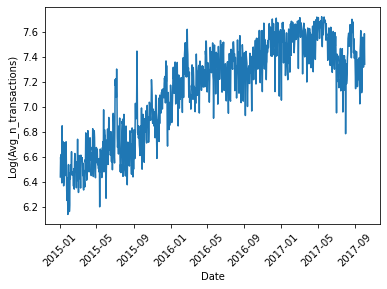

In [ ]:
# Time Series analysis of log of avg. no transactions per block over time.
plt.plot(bitcoin_data['Date'], np.log(bitcoin_data['btc_n_transactions_per_block']))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Log(Avg_n_transactions)')

###The series exhibits a trend pattern. Lets see whether, this is time dependant or the series values depend on previous ones. We consider data before 2017 August since Bitcoin blockchain experienced hard fork and was split into BTC Cash and BTC. Hence the sudden downfall in the parameter after 2017-07. We want to isolate our time series from extraneous events which could be considered equivalent of a regime change.

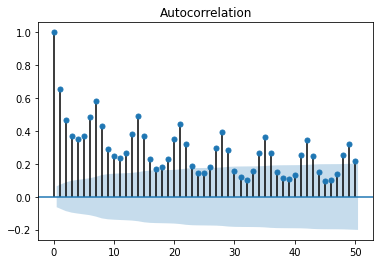

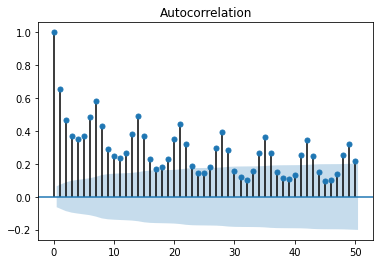

In [ ]:
block_txn = pd.DataFrame(bitcoin_data.loc[bitcoin_data['Date'] < datetime(2017,7,31), 'btc_n_transactions_per_block'])
block_txn['log_txn_block'] = np.log(block_txn[['btc_n_transactions_per_block']])
block_txn = block_txn.drop('btc_n_transactions_per_block', axis=1)

block_txn['time'] = block_txn.index - block_txn.index[0] + 1
block_txn_exog = sm.add_constant(block_txn[['time']], prepend=False)
model_txn_blk = sm.OLS(block_txn['log_txn_block'], block_txn_exog)
results_txn_blk = model_txn_blk.fit()

plot_acf(results_txn_blk.resid, lags=50)

###We regress Log(no. of transactions) = m*t + c where t is time and see whether residuals exhibit correlations. As shown above, there are significant figures for lags 1,2 and periodically in 7, 14, 21 etc. This is an indicator of Seasonality in the series. Next we model our regress our series against lag 1 and lag 7.

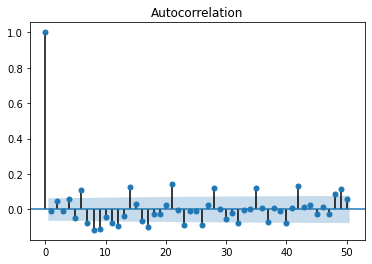

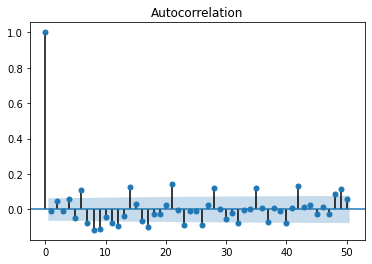

In [ ]:
block_txn['log_txn_block_lag_7'] = block_txn['log_txn_block'].shift(7)
block_txn['log_txn_block_lag_1'] = block_txn['log_txn_block'].shift(1)

block_txn = block_txn.dropna()
model_txn_blk = sm.OLS(block_txn['log_txn_block'], block_txn[['log_txn_block_lag_7', 'log_txn_block_lag_1']])
results_txn_blk = model_txn_blk.fit()
plot_acf(results_txn_blk.resid, lags=50)

###Still some lags persist. However, increasing the number of variables may increase the chances of overfitting. Hence, careful consideration should be given prior to selecting lags. The model, overall proves a good fit. We may also want to test its predictive accuracy for future data.

###Future studies should focus on modelling the probability of orphan_blocks as a function of other network variables. Miners incentive analysis can be done by feature engineering of our data. Posting update on this soon!